In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm



# paths (workspace)
sales_path = "/workspaces/TeamCPH/data/umsatzdaten_gekuerzt.csv"
wetter_path = "/workspaces/TeamCPH/data/wetter1.csv"
kiwo_path = "/workspaces/TeamCPH/data/kiwo.csv"
holidays_path = "/workspaces/TeamCPH/data/school_holidays_SH.csv"
test_path = "/workspaces/TeamCPH/data/test.csv"

# load sales and aggregate to daily total
sales = pd.read_csv(sales_path, parse_dates=["Datum"])
sales_daily = sales.groupby("Datum", as_index=False)["Umsatz"].sum()

# load weather and kieler-week flags
wetter = pd.read_csv(wetter_path, parse_dates=["Datum"])
kiwo = pd.read_csv(kiwo_path, parse_dates=["Datum"])
holidays = pd.read_csv(holidays_path, parse_dates=["Datum"])
test = pd.read_csv(test_path, parse_dates=["Datum"])

# merge: sales <- weather <- kiwo
merged = sales_daily.merge(wetter, on="Datum", how="left")
merged = merged.merge(kiwo, on="Datum", how="left")
merged = merged.merge(holidays, on="Datum", how="left")
merged = merged.merge(test, on="Datum", how="left") 

# concat test data to main data
merged = pd.concat([merged, test], ignore_index=True).drop_duplicates(subset=["Datum"], keep="last")

# fill missing KielerWoche as 0 (not festival) and sort
merged["KielerWoche"] = merged["KielerWoche"].fillna(0).astype(int)
merged = merged.sort_values("Datum").reset_index(drop=True)

# extract year-month and aggregate
merged["YearMonth"] = merged["Datum"].dt.to_period("M")

# group by month: sum revenue and count KielerWoche days
monthly = merged.groupby("YearMonth").agg({
    "Umsatz": "sum",
    "KielerWoche": "sum"
}).reset_index()

# convert YearMonth back to timestamp for plotting
monthly["YearMonth"] = monthly["YearMonth"].dt.to_timestamp()

# create variable IsWeekend
merged['IsWeekend'] = merged["Datum"].dt.weekday.isin([5, 6]).astype(int)

# create variable IsNewYears (Dec 31)
merged["IsNewYears"] = merged["Datum"].dt.strftime("%m-%d").isin(["12-31"]).astype(int)

# create variable IsHalloween (Oct 31)
halloween_days = [f"10-{day:02d}" for day in range(24, 32)]

merged["IsHalloween"] = merged["Datum"].dt.strftime("%m-%d").isin(halloween_days).astype(int)

# result
print(merged.head())
# optionally save
# merged.to_csv("/workspaces/TeamCPH/merged_daily.csv", index=False)

       Datum       Umsatz  Bewoelkung  Temperatur  Windgeschwindigkeit  \
0 2013-07-01  1269.249107         6.0     17.8375                 15.0   
1 2013-07-02  1430.008397         3.0     17.3125                 10.0   
2 2013-07-03  1124.274894         7.0     21.0750                  6.0   
3 2013-07-04  1184.309567         7.0     18.8500                  7.0   
4 2013-07-05  1288.023060         5.0     19.9750                 12.0   

   Wettercode  WeatherCategory  KielerWoche  holiday  Easter  id  Warengruppe  \
0        20.0              3.0            0      1.0     0.0 NaN          NaN   
1         NaN              1.0            0      1.0     0.0 NaN          NaN   
2        61.0              4.0            0      1.0     0.0 NaN          NaN   
3        20.0              3.0            0      1.0     0.0 NaN          NaN   
4         NaN              1.0            0      1.0     0.0 NaN          NaN   

  YearMonth  IsWeekend  IsNewYears  IsHalloween  
0   2013-07       

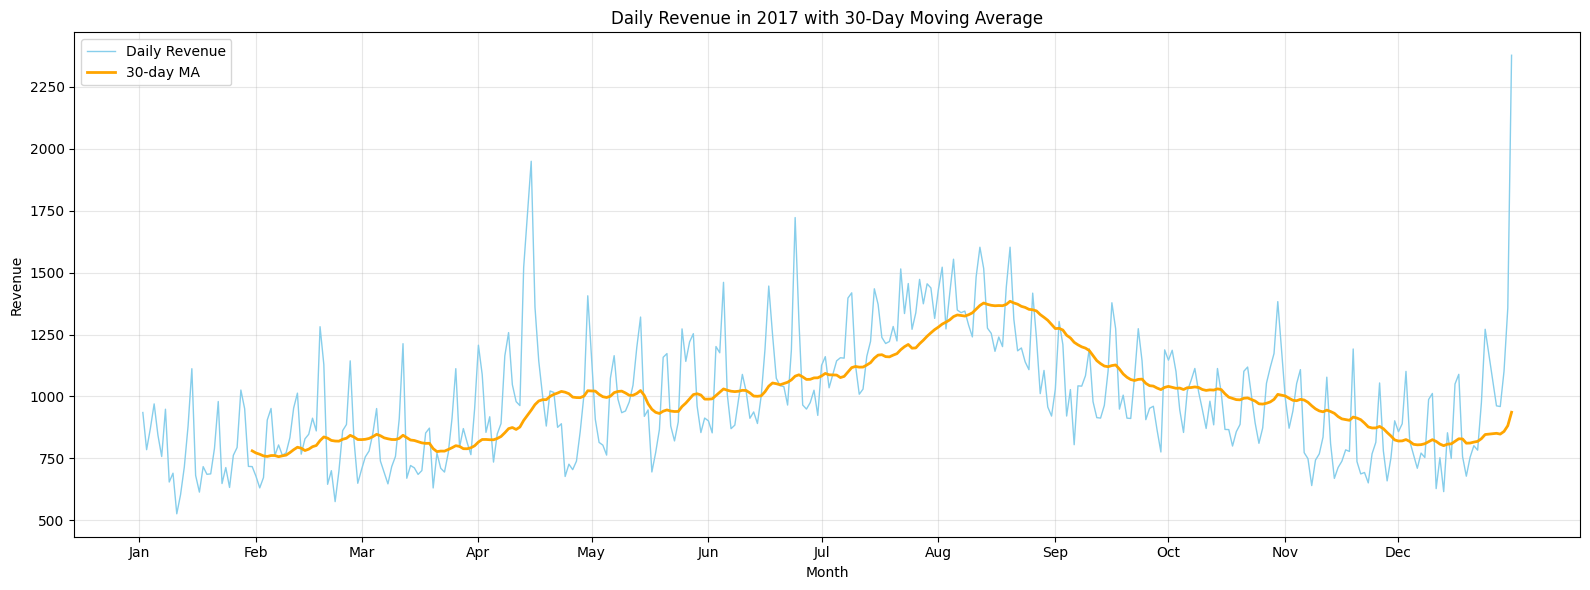

In [3]:
import matplotlib.pyplot as plt
import pandas as pd


# Filter for 2018 only
df_2017 = merged[merged["Datum"].dt.year == 2017].copy()

# Calculate 30-day moving average
df_2017["MA30"] = df_2017["Umsatz"].rolling(window=30).mean()

# Plot
plt.figure(figsize=(16, 6))

plt.plot(df_2017["Datum"], df_2017["Umsatz"], 
         label="Daily Revenue", color="skyblue", linewidth=1)

plt.plot(df_2017["Datum"], df_2017["MA30"], 
         label="30-day MA", color="orange", linewidth=2)

# Set title and labels
plt.title("Daily Revenue in 2017 with 30-Day Moving Average")
plt.xlabel("Month")
plt.ylabel("Revenue")

# Format x-axis to show months
plt.xticks(
    ticks=pd.date_range(start="2017-01-01", end="2017-12-31", freq="MS"),
    labels=[d.strftime("%b") for d in pd.date_range("2017-01-01", "2017-12-31", freq="MS")]
)

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [4]:
# translations 
merged.rename(columns={'Datum': 'Date'}, inplace=True)
merged.rename(columns={'Umsatz': 'Revenue'}, inplace=True)
merged.rename(columns={'Bewoelkung': 'CloudCover'}, inplace=True)
merged.rename(columns={'Temperatur': 'Temperature'}, inplace=True)
merged.rename(columns={'Windgeschwindigkeit': 'WindSpeed'}, inplace=True)
merged.rename(columns={'Wettercode': 'WeatherCode'}, inplace=True)
merged.rename(columns={'KielerWoche': 'KielWeek'}, inplace=True)
print(merged)

           Date      Revenue  CloudCover  Temperature  WindSpeed  WeatherCode  \
0    2013-07-01  1269.249107         6.0      17.8375       15.0         20.0   
1    2013-07-02  1430.008397         3.0      17.3125       10.0          NaN   
2    2013-07-03  1124.274894         7.0      21.0750        6.0         61.0   
3    2013-07-04  1184.309567         7.0      18.8500        7.0         20.0   
4    2013-07-05  1288.023060         5.0      19.9750       12.0          NaN   
...         ...          ...         ...          ...        ...          ...   
2169 2019-07-26          NaN         NaN          NaN        NaN          NaN   
2170 2019-07-27          NaN         NaN          NaN        NaN          NaN   
2171 2019-07-28          NaN         NaN          NaN        NaN          NaN   
2172 2019-07-29          NaN         NaN          NaN        NaN          NaN   
2173 2019-07-30          NaN         NaN          NaN        NaN          NaN   

      WeatherCategory  Kiel

In [5]:
# descriptive statistics
import numpy as np

# basic shape and info
print('Shape:', merged.shape)

# basic descriptive statistics for key variables
stats = merged[['Revenue', 'CloudCover','Temperature','WindSpeed']].describe()
print('Descriptive statistics for key variables:')
print(stats)

Shape: (2174, 16)
Descriptive statistics for key variables:
           Revenue   CloudCover  Temperature    WindSpeed
count  1819.000000  1807.000000   1816.00000  1816.000000
mean   1060.910160     4.688434     12.20778    10.996696
std     290.267632     2.650726      7.26073     4.128913
min     525.973832     0.000000     -8.47500     3.000000
25%     850.806263     3.000000      6.37500     8.000000
50%    1001.424738     6.000000     12.04375    10.000000
75%    1226.344892     7.000000     18.12500    13.000000
max    3156.413344     8.000000     31.43750    35.000000


In [6]:
# cleaning the dataset 

# analyse the 'Not a Number' (NaN) values in each column
# the intention is to remove from the dataset rows containing NaN values
nan_per_column = merged.isnull().sum()
print('NaN values in each column:')
print(nan_per_column)

# Clean NaN values only for rows before positional index 1819 (iloc)
cutoff_pos = 1819
n_rows = len(merged)

if cutoff_pos <= 0:
    # nothing to clean before 0
    merged_cleaned = merged.copy()
elif cutoff_pos >= n_rows:
    # cutoff beyond end -> clean whole dataframe
    merged_cleaned = merged.dropna(subset=['CloudCover', 'Temperature', 'WindSpeed'], how='any')
else:
    # split by positional index: pre (0..cutoff_pos-1) and post (cutoff_pos..end)
    pre = merged.iloc[:cutoff_pos].dropna(subset=['CloudCover', 'Temperature', 'WindSpeed'], how='any')
    post = merged.iloc[cutoff_pos:]
    # concat preserving original indices and order
    merged_cleaned = pd.concat([pre, post]).sort_index()

print('Original shape:', merged.shape)
print('Shape after selective cleaning:', merged_cleaned.shape)
print(merged_cleaned.head())

NaN values in each column:
Date                  0
Revenue             355
CloudCover          367
Temperature         358
WindSpeed           358
WeatherCode         814
WeatherCategory     358
KielWeek              0
holiday             355
Easter              355
id                 1819
Warengruppe        1819
YearMonth             0
IsWeekend             0
IsNewYears            0
IsHalloween           0
dtype: int64
Original shape: (2174, 16)
Shape after selective cleaning: (2162, 16)
        Date      Revenue  CloudCover  Temperature  WindSpeed  WeatherCode  \
0 2013-07-01  1269.249107         6.0      17.8375       15.0         20.0   
1 2013-07-02  1430.008397         3.0      17.3125       10.0          NaN   
2 2013-07-03  1124.274894         7.0      21.0750        6.0         61.0   
3 2013-07-04  1184.309567         7.0      18.8500        7.0         20.0   
4 2013-07-05  1288.023060         5.0      19.9750       12.0          NaN   

   WeatherCategory  KielWeek  holiday

In [7]:
nan_per_column = merged_cleaned.isnull().sum()
print('NaN values in each column:')
print(nan_per_column)

NaN values in each column:
Date                  0
Revenue             355
CloudCover          355
Temperature         355
WindSpeed           355
WeatherCode         802
WeatherCategory     355
KielWeek              0
holiday             355
Easter              355
id                 1807
Warengruppe        1807
YearMonth             0
IsWeekend             0
IsNewYears            0
IsHalloween           0
dtype: int64


In [8]:
import pandas as pd

# load the wetter.csv file
wetter = pd.read_csv("/workspaces/TeamCPH/data/wetter.csv", parse_dates=["Datum"])

# display first 100 rows
print(wetter.head(100))

        Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode
0  2012-01-01         8.0      9.8250                   14        58.0
1  2012-01-02         7.0      7.4375                   12         NaN
2  2012-01-03         8.0      5.5375                   18        63.0
3  2012-01-04         4.0      5.6875                   19        80.0
4  2012-01-05         6.0      5.3000                   23        80.0
..        ...         ...         ...                  ...         ...
95 2012-04-05         1.0      5.6375                   10         NaN
96 2012-04-06         7.0      6.2000                   18        61.0
97 2012-04-07         4.0      3.7125                   19         NaN
98 2012-04-08         2.0      5.7500                   10         NaN
99 2012-04-09         8.0      6.5125                   10        58.0

[100 rows x 5 columns]


In [9]:
print(merged_cleaned.head(10))

        Date      Revenue  CloudCover  Temperature  WindSpeed  WeatherCode  \
0 2013-07-01  1269.249107         6.0      17.8375       15.0         20.0   
1 2013-07-02  1430.008397         3.0      17.3125       10.0          NaN   
2 2013-07-03  1124.274894         7.0      21.0750        6.0         61.0   
3 2013-07-04  1184.309567         7.0      18.8500        7.0         20.0   
4 2013-07-05  1288.023060         5.0      19.9750       12.0          NaN   
5 2013-07-06  1540.529898         0.0      18.9625        8.0          NaN   
6 2013-07-07  1532.372927         0.0      21.3750        9.0          NaN   
7 2013-07-08  1203.921695         0.0      22.7250       10.0          5.0   
8 2013-07-09  1385.112329         0.0      23.2750        8.0          NaN   
9 2013-07-10  1384.765939         2.0      19.6875       13.0          5.0   

   WeatherCategory  KielWeek  holiday  Easter  id  Warengruppe YearMonth  \
0              3.0         0      1.0     0.0 NaN          NaN   

  weekday     Revenue
   Monday  993.311731
  Tuesday  965.657881
Wednesday  957.760869
 Thursday  996.287439
   Friday 1008.074795
 Saturday 1235.966898
   Sunday 1273.243223


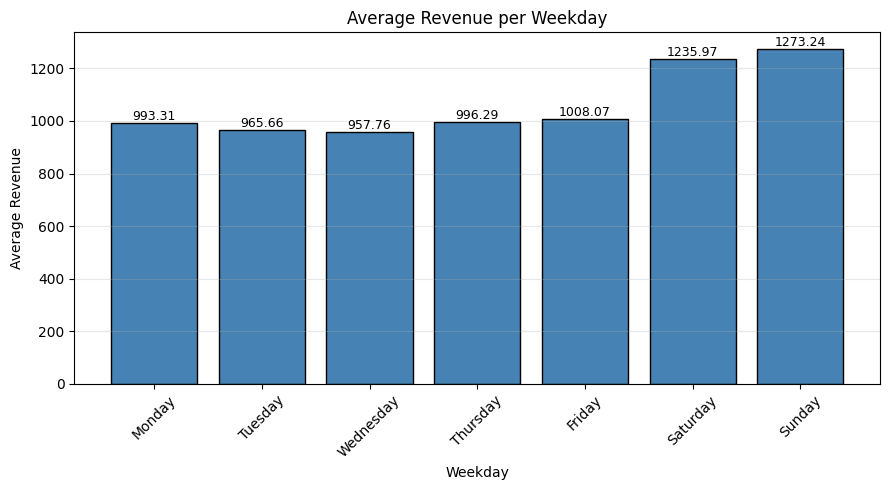

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# determine column names robustly
if 'merged_cleaned' not in globals():
    raise KeyError("DataFrame 'merged_cleaned' not found in the notebook namespace.")

revenue_col = 'Revenue' if 'Revenue' in merged_cleaned.columns else ('Umsatz' if 'Umsatz' in merged_cleaned.columns else None)
date_col = 'Date' if 'Date' in merged_cleaned.columns else ('Datum' if 'Datum' in merged_cleaned.columns else None)

if revenue_col is None:
    raise KeyError("Keine Spalte 'Umsatz' oder 'Revenue' in merged_cleaned gefunden.")
if date_col is None:
    raise KeyError("Keine Spalte 'Datum' oder 'Date' in merged_cleaned gefunden.")

# ensure date column is datetime
merged_cleaned[date_col] = pd.to_datetime(merged_cleaned[date_col])

# prepare aggregated data: average revenue per weekday (Mon-Sun)
df = merged_cleaned[[date_col, revenue_col]].copy()
df['weekday_num'] = df[date_col].dt.weekday  # Monday=0
df['weekday'] = df[date_col].dt.day_name()

avg_by_weekday = df.groupby(['weekday_num', 'weekday'])[revenue_col].mean().reset_index()
avg_by_weekday = avg_by_weekday.sort_values('weekday_num')

# show table
print(avg_by_weekday[['weekday', revenue_col]].to_string(index=False))

# plot
fig, ax = plt.subplots(figsize=(9,5))
bars = ax.bar(avg_by_weekday['weekday'], avg_by_weekday[revenue_col], color='steelblue', edgecolor='black')
ax.set_xlabel('Weekday')
ax.set_ylabel(f'Average {revenue_col}')
ax.set_title('Average Revenue per Weekday')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

# annotate values above bars
for bar, val in zip(bars, avg_by_weekday[revenue_col]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{val:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Average Umsatz per Warengruppe:
product_name     Umsatz
     1=Bread 122.142509
     2=Roles 402.497911
 3=Croissant 163.340920
    4=Pastry  87.954042
     5=Cakes 276.795509
  6=Seasonal  66.916635


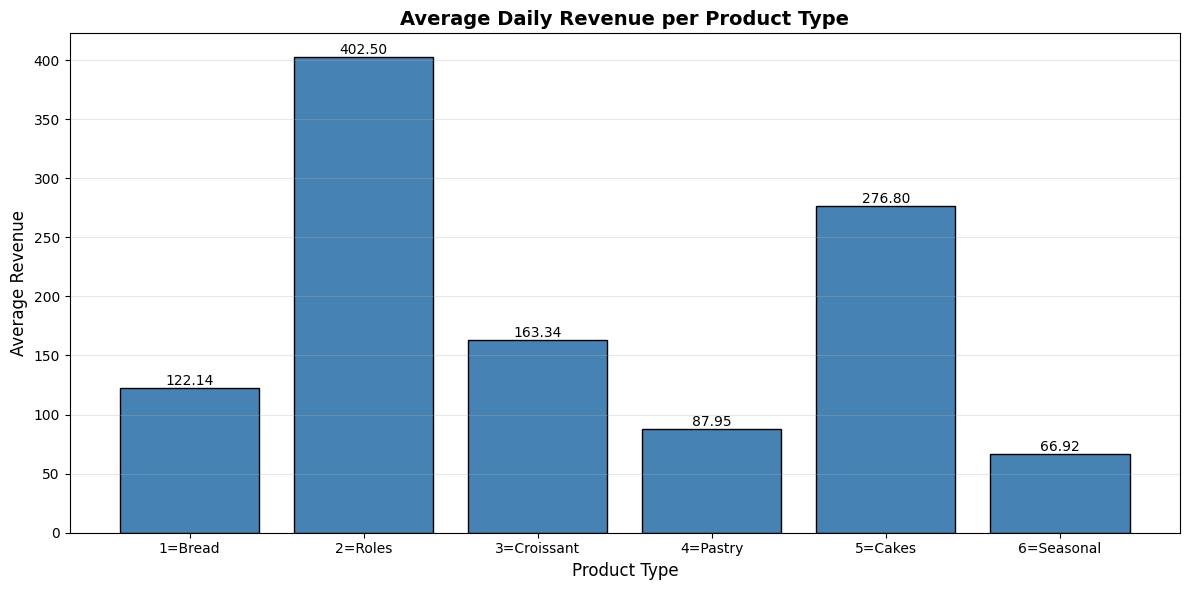

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# determine product column name
product_col = 'Warengruppe' if 'Warengruppe' in sales.columns else None
revenue_col = 'Umsatz' if 'Umsatz' in sales.columns else None

if product_col is None or revenue_col is None:
    raise KeyError("Spalten 'Warengruppe' oder 'Umsatz' nicht in sales DataFrame gefunden.")

# calculate average revenue per product type
avg_by_product = sales.groupby(product_col)[revenue_col].mean().reset_index()
avg_by_product = avg_by_product.sort_values(product_col)  # Sort by product type (1-6)

# create mapping for product names
product_mapping = {
    1: "1=Bread",
    2: "2=Roles",
    3: "3=Croissant",
    4: "4=Pastry",
    5: "5=Cakes",
    6: "6=Seasonal"
}

# map product codes to names
avg_by_product['product_name'] = avg_by_product[product_col].map(product_mapping)

# display table
print(f"Average {revenue_col} per {product_col}:")
print("=" * 50)
print(avg_by_product[['product_name', revenue_col]].to_string(index=False))

# create bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(avg_by_product['product_name'], avg_by_product[revenue_col], color='steelblue', edgecolor='black')
ax.set_xlabel('Product Type', fontsize=12)
ax.set_ylabel('Average Revenue', fontsize=12)
ax.set_title(f'Average Daily Revenue per Product Type', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0, ha='center')

# annotate values above bars
for bar, val in zip(bars, avg_by_product[revenue_col]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{val:.2f}", 
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [12]:
print(merged_cleaned)

           Date      Revenue  CloudCover  Temperature  WindSpeed  WeatherCode  \
0    2013-07-01  1269.249107         6.0      17.8375       15.0         20.0   
1    2013-07-02  1430.008397         3.0      17.3125       10.0          NaN   
2    2013-07-03  1124.274894         7.0      21.0750        6.0         61.0   
3    2013-07-04  1184.309567         7.0      18.8500        7.0         20.0   
4    2013-07-05  1288.023060         5.0      19.9750       12.0          NaN   
...         ...          ...         ...          ...        ...          ...   
2169 2019-07-26          NaN         NaN          NaN        NaN          NaN   
2170 2019-07-27          NaN         NaN          NaN        NaN          NaN   
2171 2019-07-28          NaN         NaN          NaN        NaN          NaN   
2172 2019-07-29          NaN         NaN          NaN        NaN          NaN   
2173 2019-07-30          NaN         NaN          NaN        NaN          NaN   

      WeatherCategory  Kiel

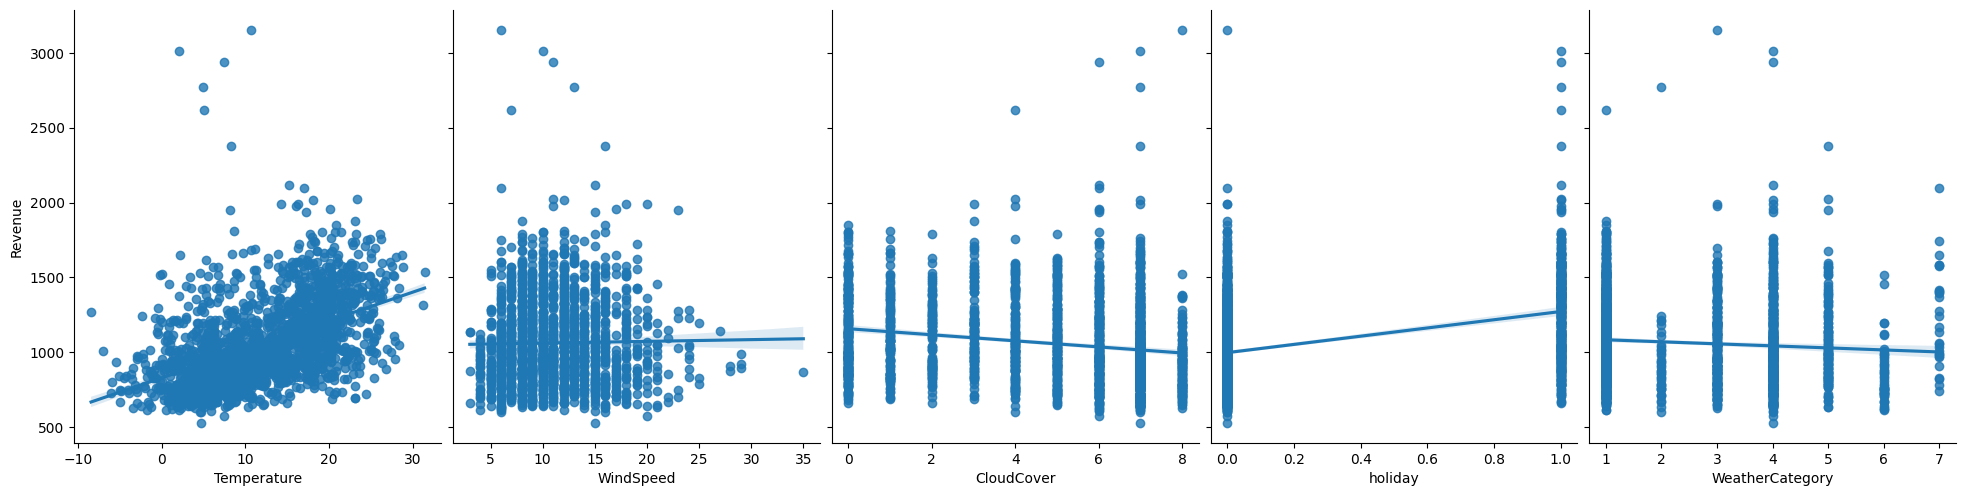

In [13]:

import seaborn as sns

sns.pairplot(merged_cleaned, 
             x_vars=['Temperature', 'WindSpeed', 'CloudCover', 'holiday', 'WeatherCategory'], 
             y_vars='Revenue', 
             height=5, 
             aspect=0.8, 
             kind='reg')

plt.show()

In [14]:
# ...existing code...
# new cell: inspect WeatherCode values and counts
df = merged_cleaned if 'merged_cleaned' in globals() else (merged if 'merged' in globals() else None)
if df is None:
    raise KeyError("Neither 'merged_cleaned' nor 'merged' found in the notebook namespace.")

# find weather-code column
candidates = [c for c in df.columns if c.lower() in ('weathercode', 'wettercode')]
if not candidates:
    raise KeyError("WeatherCode column not found. Available columns: " + ", ".join(df.columns))

col = candidates[0]
print(f"Using column: {col}  (dtype: {df[col].dtype})\n")

vc = df[col].value_counts(dropna=False).sort_index()
print("Value counts (including NaN):")
print(vc.to_string())

print("\nNumber of unique values (including NaN):", df[col].nunique(dropna=False))
# ...existing code...

Using column: WeatherCode  (dtype: float64)

Value counts (including NaN):
WeatherCode
0.0     160
3.0       1
5.0     112
10.0    141
17.0      1
20.0     48
21.0    198
22.0     17
28.0     12
45.0     18
49.0      9
53.0      6
61.0    438
63.0    103
65.0     22
68.0      2
69.0      5
71.0     16
73.0      9
75.0      5
77.0      9
79.0      1
95.0     27
NaN     802

Number of unique values (including NaN): 24


<Axes: xlabel='WeatherCategory', ylabel='Revenue'>

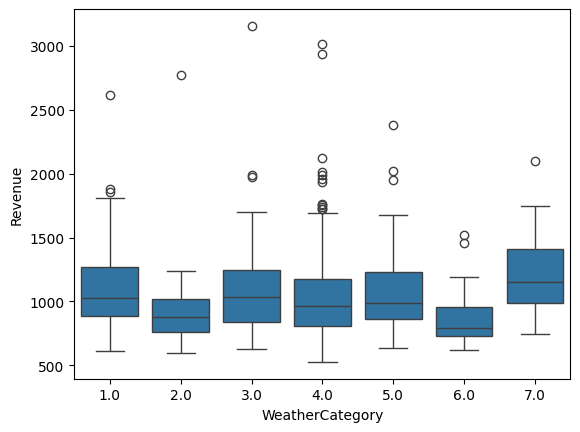

In [ ]:
import seaborn as sns
sns.boxplot(data=merged_cleaned, x="WeatherCategory", y="Revenue")

# 1 Clear, sunny, dry
# 2 Fog
# 3 Rain stopped
# 4 Light rain
# 5 Moderate to strong rain
# 6 Snow
# 7 Thunderstorm

In [16]:
merged_cleaned.loc[merged_cleaned["Date"] == pd.Timestamp("2018-07-31")]


,Date,Revenue,CloudCover,Temperature,WindSpeed,WeatherCode,WeatherCategory,KielWeek,holiday,Easter,id,Warengruppe,YearMonth,IsWeekend,IsNewYears,IsHalloween
1818,2018-07-31,1313.474071,5.0,31.2875,11.0,NaN,1.0,0,1.0,0.0,NaN,NaN,2018-07,0,0,0


In [17]:
df = merged_cleaned


In [18]:
# Split dataset into train/validation/test by date ranges (inclusive)

# use merged_cleaned if available, otherwise fall back to merged
df = merged_cleaned if 'merged_cleaned' in globals() else (merged if 'merged' in globals() else None)
if df is None:
    raise KeyError("Neither 'merged_cleaned' nor 'merged' found in notebook namespace.")

# robust date column lookup
date_col = 'Date' if 'Date' in df.columns else ('Datum' if 'Datum' in df.columns else None)
if date_col is None:
    raise KeyError("No date column found ('Date' or 'Datum').")

# ensure datetime
df[date_col] = pd.to_datetime(df[date_col])

# define inclusive ranges
train_start = pd.Timestamp('2013-07-01')
train_end   = pd.Timestamp('2017-07-31')
val_start   = pd.Timestamp('2017-08-01')
val_end     = pd.Timestamp('2018-07-31')
test_start  = pd.Timestamp('2018-08-01')
test_end    = pd.Timestamp('2019-07-31')

# filter
train_df = df[(df[date_col] >= train_start) & (df[date_col] <= train_end)].copy()
val_df   = df[(df[date_col] >= val_start)   & (df[date_col] <= val_end)].copy()
test_df  = df[(df[date_col] >= test_start)  & (df[date_col] <= test_end)].copy()

# quick sanity prints
def summary(name, d):
    if d.empty:
        print(f"{name}: EMPTY")
    else:
        print(f"{name}: rows={d.shape[0]}, dates={d[date_col].min().date()} - {d[date_col].max().date()}")

summary('Train', train_df)
summary('Validation', val_df)
summary('Test', test_df)

# Optional: persist to CSV if needed
# train_df.to_csv('/workspaces/TeamCPH/train_20130701_20170731.csv', index=False)
# val_df.to_csv('/workspaces/TeamCPH/val_20170801_20180731.csv', index=False)
# test_df.to_csv('/workspaces/TeamCPH/test_20180801_20190731.csv', index=False)

Train: rows=1461, dates=2013-07-01 - 2017-07-31
Validation: rows=346, dates=2017-08-01 - 2018-07-31
Test: rows=355, dates=2018-08-01 - 2019-07-30


In [19]:
print(df)

           Date      Revenue  CloudCover  Temperature  WindSpeed  WeatherCode  \
0    2013-07-01  1269.249107         6.0      17.8375       15.0         20.0   
1    2013-07-02  1430.008397         3.0      17.3125       10.0          NaN   
2    2013-07-03  1124.274894         7.0      21.0750        6.0         61.0   
3    2013-07-04  1184.309567         7.0      18.8500        7.0         20.0   
4    2013-07-05  1288.023060         5.0      19.9750       12.0          NaN   
...         ...          ...         ...          ...        ...          ...   
2169 2019-07-26          NaN         NaN          NaN        NaN          NaN   
2170 2019-07-27          NaN         NaN          NaN        NaN          NaN   
2171 2019-07-28          NaN         NaN          NaN        NaN          NaN   
2172 2019-07-29          NaN         NaN          NaN        NaN          NaN   
2173 2019-07-30          NaN         NaN          NaN        NaN          NaN   

      WeatherCategory  Kiel

In [ ]:
# multilinear regression model
predictors = [
    "Temperature",
    "KielWeek",
    "holiday",
    "IsWeekend",
    "IsNewYears",
    "Easter",
    "IsHalloween"
]

Y = train_df ["Revenue"]
X = sm.add_constant(train_df[predictors])

model = sm.OLS(Y,X)

results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     343.5
Date:                Thu, 11 Dec 2025   Prob (F-statistic):          1.78e-274
Time:                        14:55:19   Log-Likelihood:                -9733.5
No. Observations:                1461   AIC:                         1.948e+04
Df Residuals:                    1454   BIC:                         1.952e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         737.2624     10.505     70.184      

In [21]:
# predict Revenue

m1 = results.params["Temperature"]
m2 = results.params["KielWeek"]
m3 = results.params["holiday"]
b = results.params["const"]

Temperature = 20
KielWeek = 1
Holiday = 0

Revenue = m1 * Temperature + m2 * KielWeek + m3 * Holiday + b
print(f"Predicted Revenue for {Temperature}°C: {Revenue:.2f}")

Predicted Revenue for 20°C: 1185.92


In [22]:
merged_cleaned["IsHalloween"].value_counts()

IsHalloween
0    2117
1      45
Name: count, dtype: int64